# 2. Do basic descriptive analysis

We wanted to analyse how many Parlimentary written questions could not be answered because the department did not have the requisite data, and what those questions were about.

We first obtained text for all the written answers in the current Parliament from TheyWorkForYou. 

In this notebook:

- we perform high-level analysis on this data to get a sense of how many questions are asked, who asks them, and how many of them are quantitative
- we identify common strings that may indicate questions that could not be answered due to lack of data
- we write these questions to separate files for manual review. 

We subsequently reviewed these questions manually, to see which of these questions were truly unanswered, and what themes recurred for each Department.

NB: The text of Hansard answers remains under [Parliamentary copyright](https://www.parliament.uk/site-information/copyright-parliament/).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('./data/output/questions_with_flags.csv', low_memory=False)
len(df)

47635

## Examine question frequency over time

These largely seem to follow the [patterns of Parliamentary recess](https://www.parliament.uk/about/faqs/house-of-commons-faqs/business-faq-page/recess-dates/).

Note that a small number of questions were submitted prior to the period, but only answered later - this doesn't matter for the purpose of our analysis. Note also that this dataset only contains answered questions, there may be others that haven't been answered yet.

In [3]:
df.date_submitted = pd.to_datetime(df.date_submitted)
df.date_answered = pd.to_datetime(df.date_answered)

<Axes: title={'center': 'Count of questions answered by month'}, xlabel='date_answered,date_answered'>

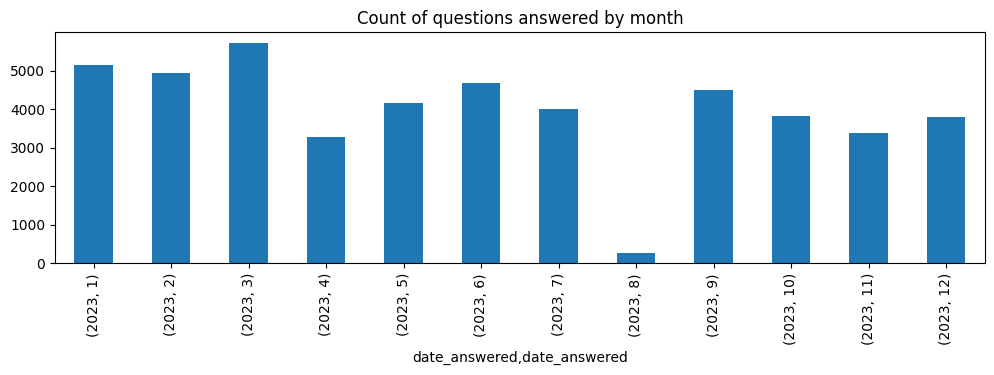

In [4]:
df.groupby([df.date_answered.dt.year, df.date_answered.dt.month]).url.size()\
    .plot(kind="bar", title="Count of questions answered by month", figsize=(12, 3))

## Which departments get asked most WQs?

DHSC by a factor of two - even before Covid. Note there were departmental splits and merges over the period, particularly in BEIS.

In [5]:
pd.concat([df.department.value_counts().head(10), 
           df.department.value_counts(normalize=True).head(10) * 100], 
          axis=1)

,count,proportion
department,,
Department of Health and Social Care,8233,17.283510
"Foreign, Commonwealth and Development Office",4525,9.499318
Home Office,4109,8.626010
Department for Transport,3341,7.013750
"Department for Environment, Food and Rural Affairs",3276,6.877296
Ministry of Defence,3200,6.717750
Department for Education,3138,6.587593
Department for Work and Pensions,2534,5.319618
Department for Energy Security and Net Zero,2305,4.838879


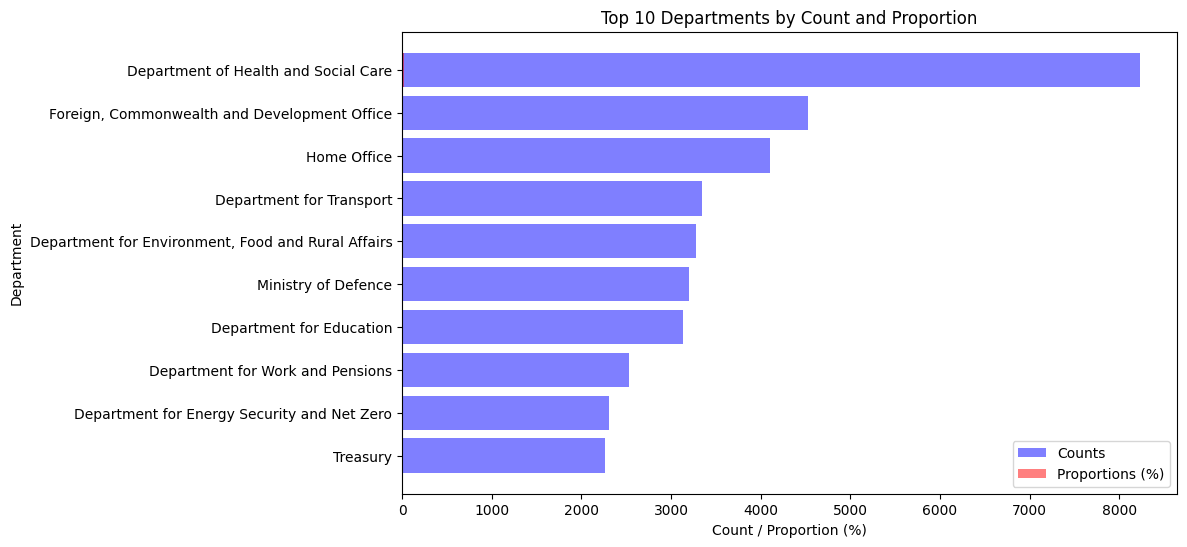

In [6]:
import matplotlib.pyplot as plt

# Calculate value counts and proportions
counts = df.department.value_counts().head(10)
proportions = df.department.value_counts(normalize=True).head(10) * 100

# Create a new figure and set its size
plt.figure(figsize=(10, 6))

# Create a horizontal bar chart of the counts
plt.barh(counts.index, counts.values, color='blue', alpha=0.5, label='Counts')

# Create a horizontal bar chart of the proportions
plt.barh(proportions.index, proportions.values, color='red', alpha=0.5, label='Proportions (%)')

# Add labels and title
plt.xlabel('Count / Proportion (%)')
plt.ylabel('Department')
plt.title('Top 10 Departments by Count and Proportion')
plt.legend()

# Invert the y-axis so the department with the highest count is on top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

Chart questions to each major department, by month. 

<Axes: xlabel='date_submitted,date_submitted'>

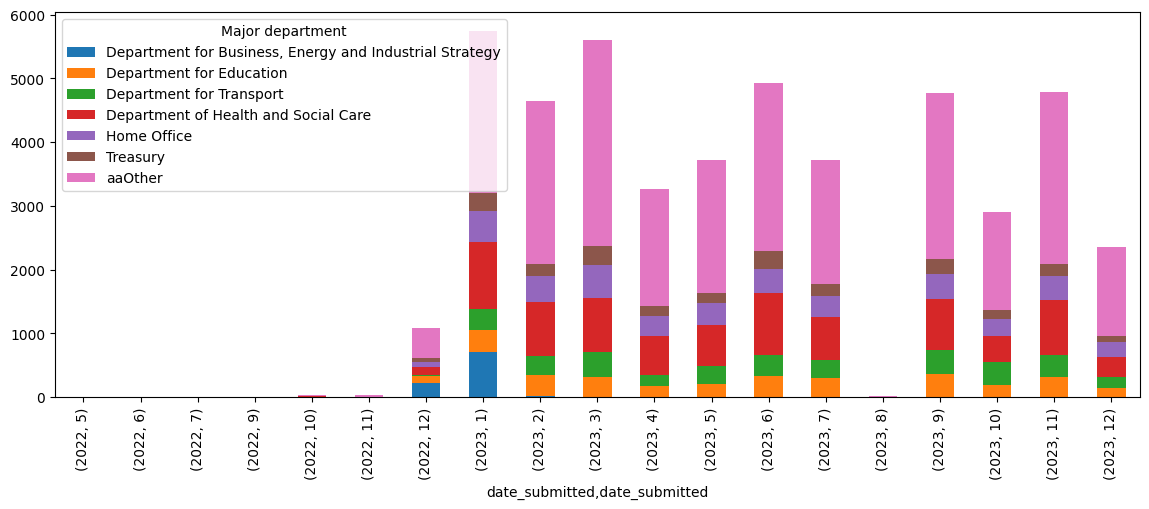

In [8]:
def get_major_department(dept):
    if dept != 'Department of Health and Social Care' \
        and dept != 'Home Office' \
        and dept != 'Treasury'\
        and dept != 'Department for Transport' \
        and dept != 'Department for Education'\
        and dept != 'Foreign and Commonwealth Office' \
        and dept != 'Department for Business, Energy and Industrial Strategy' \
        and dept != 'Ministry of Housing, Communities and Local Government':
        return 'aaOther'
    return dept
df['Major department'] = df.department.apply(get_major_department)
df.groupby([df.date_submitted.dt.year, df.date_submitted.dt.month, df['Major department']]).url.count()\
    .unstack(level=-1) \
    .plot(kind="bar", stacked=True, figsize=(14,5))

## Who asks the most WQs?

Shadow ministers tend to ask lots, unsurprisingly. Some opposition backbenchers can be very active too.

In [28]:
print(len(df.question_speaker.value_counts()), "people asked questions over the period")

1163 people asked questions over the period


In [29]:
df.groupby(['question_speaker', 'question_position']).url.count().sort_values(ascending=False).head(10)

question_speaker        question_position                                                       
Rachael Maskell         Labour/Co-operative, York Central                                           3961
John Healey             Shadow Secretary of State for Defence                                       2729
Jim Shannon             Shadow DUP Spokesperson (Human Rights), Shadow DUP Spokesperson (Health)    2702
Tan Dhesi               Shadow Minister (Transport)                                                 2220
Rachael Maskell         Shadow Minister (Digital, Culture, Media and Sport)                         2076
Caroline Lucas          Green, Brighton, Pavilion                                                   2062
Kevan Jones             Labour, North Durham                                                        2029
Matthew Offord          Conservative, Hendon                                                        1898
Andrew Rosindell        Conservative, Romford                  

## Utility: Save a particular department's WQs, to read

Convenience code for outputing a particular department's WQs, without superfluous columns.

In [12]:
df.question_text = df.question_text.str.strip()
cols_in_order = [
    'title', 'url',
    'question_text', 'answer_text',
    'is_quantitative', 'contains_not_held_string',
    'contains_not_held_string_and_isquant',
    'contains_not_possible_string',
    'date_submitted', 'date_answered',
    'question_speaker', 'question_position',
    'answer_speaker', 'answer_position',
]

In [10]:
df.department.unique()

array(['Home Office', 'Ministry of Justice',
       'Department for Digital, Culture, Media and Sport',
       'Department of Health and Social Care',
       'Department for Business, Energy and Industrial Strategy',
       'Foreign, Commonwealth and Development Office',
       'Department for Transport', 'Department for Education',
       'Department for Environment, Food and Rural Affairs',
       'Department for Levelling Up, Housing and Communities', 'Treasury',
       'Northern Ireland Office', 'Cabinet Office', 'Ministry of Defence',
       'Department for Work and Pensions',
       'Department for International Trade',
       'Leader of the House of Lords', 'The Senior Deputy Speaker',
       'Attorney General', 'Scotland Office', 'Women and Equalities',
       'Leader of the House', 'Wales Office',
       'House of Commons Commission',
       'Restoration and Renewal Client Board', 'Prime Minister',
       'Church Commissioners',
       "Speaker's Committee on the Electoral Com

In [13]:
import pandas as pd
import os

# Update the departments dictionary with the departments you want to keep
departments = {
    # "Department of Health and Social Care": "dhsc",
    # "Department for Education": "dfe",
    # "Department for Work and Pensions": "dwp",
    # "Home Office": "ho",
    # "Ministry of Defence": "mod",
    "Department for Transport": "dft",
    # Add more departments as needed
}

output_dir = './data/by_department'

# Check if the directory exists
if not os.path.exists(output_dir):
    # If not, create it
    os.makedirs(output_dir)

# Iterate over the departments
for name, acronym in departments.items():
    # Create a subframe for the current department
    df_for_department = df[df.department == name][cols_in_order]
    
    # Sense check: print the number of rows in the subframe
    print(f"{name} ({acronym}): {len(df_for_department)} rows")
    
    # Save the subframe to a CSV file
    df_for_department.to_csv(f'{output_dir}/{acronym}.csv', index=False)

Department for Transport (dft): 3341 rows


In [15]:
department = "Department for Transport"
print(len(df_for_department), "questions to %s in this Parliament" % departments[department])
print(len(df_for_department[df_for_department.is_quantitative]), "were quantitative")
print(len(df_for_department[df_for_department.contains_not_held_string_and_isquant]), "of those were marked as unanswered")

3341 questions to dft in this Parliament
538 were quantitative
94 of those were marked as unanswered


In [25]:
# Top 10 topics for unanswered questions
df_for_department[df_for_department.contains_not_held_string_and_isquant].title.value_counts().head(10)

title
Electric Vehicles: Charging Points               4
Railways: Tickets                                3
Roads: Accidents                                 3
Buses: Exhaust Emissions                         2
Avanti West Coast: Standards                     2
Driving Tests                                    2
TransPennine Express: Standards                  2
Roads: Repairs and Maintenance                   2
Wind Power: Seas and Oceans                      2
Department for Transport: Public Consultation    2
Name: count, dtype: int64

In [36]:
import textwrap

# Set the title to filter
title_to_filter = "Electric Vehicles: Charging Points"  # Replace with your title
# Set the width for the line breaks
width = 100

# Filter the DataFrame based on the title
df_for_title = df_for_department[df_for_department.contains_not_held_string_and_isquant]
# df_for_title = df_for_title[df_for_title.title == title_to_filter]

# Iterate over the rows in the DataFrame
for index, row in df_for_title.iterrows():
    # Print the question
    print("QUESTION:")
    print(textwrap.fill(row.question_text, width))
    print("")
    
    # Print the answer
    print("ANSWER:")
    print(textwrap.fill(row.answer_text, width))
    print("\n---\n")

QUESTION:
To ask the Secretary of State for Transport, how many electric vehicle charging points there has
been in each region of the UK in each of the last five years.

ANSWER:
The Department holds data on the number of publicly available electric vehicle charging devices in
the UK as provided by the electric vehicle and charging point platform Zap-Map.It also holds
information on chargepoints and sockets that have been applied for and installed under one of the
Office for Zero Emission Vehicles (OZEV) provided grant schemes in public, residential and workplace
locations. Information on chargepoints that have been privately installed are not held, therefore
the total count of charging devices in the UK will be higher than the figures given below.DfT began
collecting the number of publicly available chargepoints at midnight on 01 October 2019. This data
is given in the table below:Table 1: Total number of publicly available charging devices, as at
midnight 01 October 2022 from 2019 onw